In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
df = pd.read_csv('data/csv/s2-corpus-002_lang.csv')

# A bit of EDA on the data

This has been done on only one file out of 40, this one file contains million records.
As a pre-processing the following steps were preformed:

* Entries with empty abstract were removed. (see `/src/trainTex/trainingFunction.py`)
* Abstracts with less then five sentances (done by splitting at '.' and checking the length) were removed . (see `/utilityScripts/create_reduced_dataset_one_file.py`)
* Abstracts were passed through `polyglot` language detector and a *Language* column was added (see `/utilityScripts/add_language.py`)

Lets check how many record we are left with:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350202 entries, 0 to 350201
Data columns (total 7 columns):
Unnamed: 0       350202 non-null int64
id               350202 non-null object
paperAbstract    350202 non-null object
title            350202 non-null object
year             350024 non-null float64
journalName      350202 non-null object
lang             350202 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 18.7+ MB


Almost 600K records. There are two wiredly named columns there that were added in my **heroic** battle with several bugs in pandas/python/internal csv library and the fact that some of the abstracts have non standard characters. They cannot be removed and for the purpose of EDA they can stay there. <br>
Lets check out the language of the abstracts:

In [6]:
lang_count = df.groupby('lang').lang.count()
print(lang_count)

lang
Afrikaans                 2
Azerbaijani               1
Chinese                   4
Croatian                  1
Czech                     2
Danish                    4
Dutch                    36
English              345490
Estonian                  1
French                  421
Galician                  1
German                 3832
Italian                  26
Japanese                  2
Korean                    1
Latin                     4
Luxembourgish             1
Norwegian Nynorsk         2
Polish                    1
Portuguese               14
Russian                  42
Scots                     2
Slovak                    1
Slovenian                 1
Spanish                 166
Turkish                   3
Ukrainian                 1
un                        2
unKnown                 138
Name: lang, dtype: int64


Quite the list..... <br>
As expected the vast majority of abstracts are in English. 
German have more then 1000 abstracts, which I think makes sense as it used to be one of the main acdemic languages.
Lets check some German abstracts to see if they are indeed German:

In [7]:
df[df.lang == 'Azerbaijani'].paperAbstract.iloc[0]

'Ab^r.irt: Human \\olunt<’crs were exposed. unt.li’r nn-dical surveillance. ro 34 g of a 5°o formulation cOEisisting of 5"o Mubam’1"^ (t-iK-n^othienyI-^-irK-thylcarbamatft’’ in pyr;ix powder \\\\v;wi lo evaluate ihe foimnlation’h porcniial valm-’ as a louse toxicant. The icst was conciucKid at tlic Republic of Keif-a’;! Anny Disciplinary Cunicr. .it Kwangju. iirai Sroul. Korea fioin Jainiary to -\\Lirc:i 1"K9. TIie u-si ptinicipanfi were divided .into ^ groups *>f 100 mrn carli and dusted once in ihc followinij; manner; the control grouu was (.iustrd with an average of 17 g pyrax powder; the CCM group was treated wilh an a\\Tiagc of 31 g of the lesc formulation; and a tliild positive control group was dustfd wilh ;m average of 20 q of Po malalhion in iiu’rc powder. Applications of Mobam’lS dust usiing'

All the journal names seems to be German (except from the 'European Journal of Wood and Wood products', it is now became my life goal to publish something there...) There are actually a few misses, but they are a few from a small fraction anyway so we can safely ignore them. 

While I don't see any reason why there will not be publications in Luxembourgish (which I totaly knew is the official language of Luxembourg https://en.wikipedia.org/wiki/Luxembourgish)  the fact that there is just one abstract in this language makes it obvious that this is a misclassification. <br>
Lets check this out:

In [8]:
df[df.lang == 'Luxembourgish'].paperAbstract

122972    1. Rupert, P.B. & Ferré-D’Amaré, A.R. Nature, ...
Name: paperAbstract, dtype: object

While I only understand Nature but I'm pretty sure this is not Luxembourgish. It looks like nonsense that passed the length check as it contains more then five `.` which translates to more then five sentences. <br>
I'll have to decide weather to take care of this stuff here or at the conversion time (probably not count sentences shorter then a threshold, this will also take care of stuff like : 'Rupert P.B'). It may be too time consuming to pass all strings through this check and the language classification seems to filter them quite good. <br>
from now I'll assume that every language with less then 4 publications is just misclassification or nonsense <br>

Some abstracts have both English and some native language, for example:

In [9]:
df[df.lang == 'Turkish'].paperAbstract.iloc[0]

'Any digital signal processing algorithm or processor can be reasonably described as a digital filter. The main advantage of an infinite impulse response filter is that it can provide a much better performance than the finite impulse response filter having the same number of coefficients. However, they might have a multi-modal error surface. Differential Evolution (DE) algorithm is a new heuristic approach mainly having three advantages; finding the true global minimum of a multi modal search space, fast convergence, and using a few control parameters. In this work, DE algorithm has been applied to the design of digital IIR filters and compared its performance to that of genetic algorithm. 1. Giriş Sayısal süzgeçler genel olarak iki grupta sınıflandırılırlar : geribeslemesiz ve geribeslemeli süzgeçler. Geribeslemesiz veya sonlu darbe cevaplı süzgeçlerin cevapları giriş işaretinin sadece o andaki ve geçmişteki değerlerine bağımlıdır. Geribeslemeli veya sonsuz darbe cevaplı süzgeçlerin c

In the final analisys only the abstracts that were identified as English will be taken into account. Mixed abstracts will be removed as the foreign words will just inflate the classifier corpus. Few as they are it does not worth the time nvestment trying to seperate them.

In [10]:
df_filt = df[df.lang.map(lambda x: lang_count[x] > 4)]
df_filt = df_filt[~(df_filt.lang.str.contains('un'))]
df_filt = df_filt[~(df_filt.lang.str.contains('unKnown'))]

## And some graphical EDA

Abstract count by language (on a log scale otherwise English just dwarfs everything)

In [11]:
lang_count = df_filt.groupby('lang').lang.count()

Text(0.5,0,'Number of Abstracts')

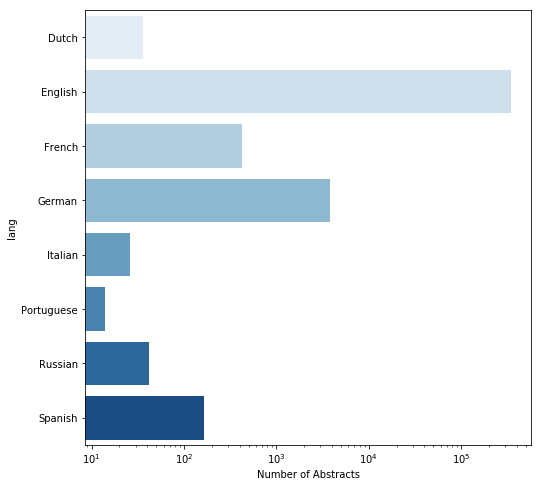

In [12]:
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(y=lang_count.index, x=lang_count, palette='Blues')
ax.set_xscale('log')
plt.xlabel('Number of Abstracts')

This is a logaritmic scale, so English have not real compatitors, why are there so many Turkish publications??? <br>
Next we will check publication counts per year:

### And a scatter plot of papers count per year:

In [13]:
year_count = df.groupby('year')['year'].count()

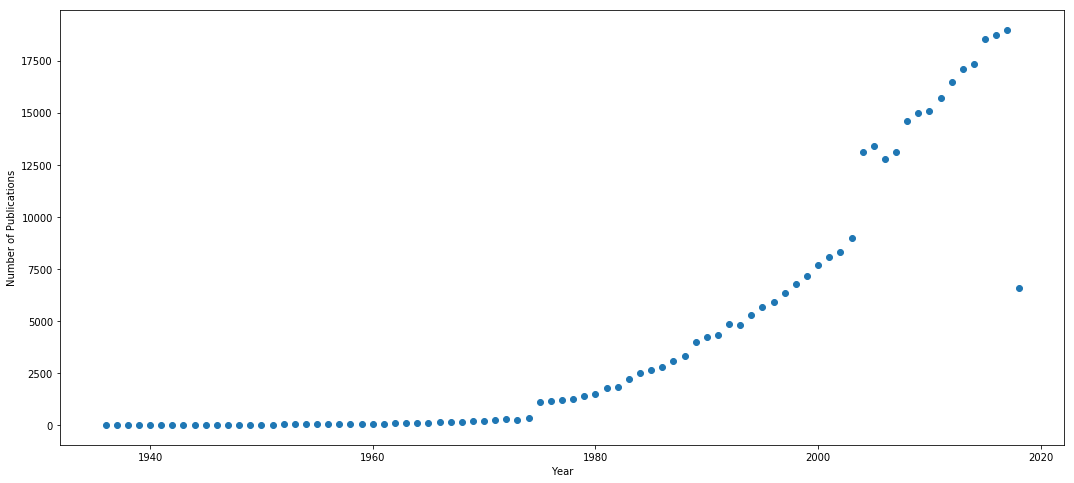

In [14]:
f, ax = plt.subplots(figsize=(18, 8))

_=plt.scatter(x=year_count.index.values, y=year_count)
plt.xlabel('Year');
plt.ylabel('Number of Publications');

Seems like there is a huge jump in the late 70's when personal computers entered the market. Another jump when the internet became popular, and it seems to be growing  exponentially. I'm leaving academia on time :)

# Checking the publication distribution by journal

In [15]:
journal_count = year_count = df.groupby('journalName').count().sort_values(by='id', ascending=False).id

In [16]:
print('There are {} different journals in the database'.format(journal_count.shape[0]))

There are 20207 different journals in the database


Text(0.5,0,'Number of publication')

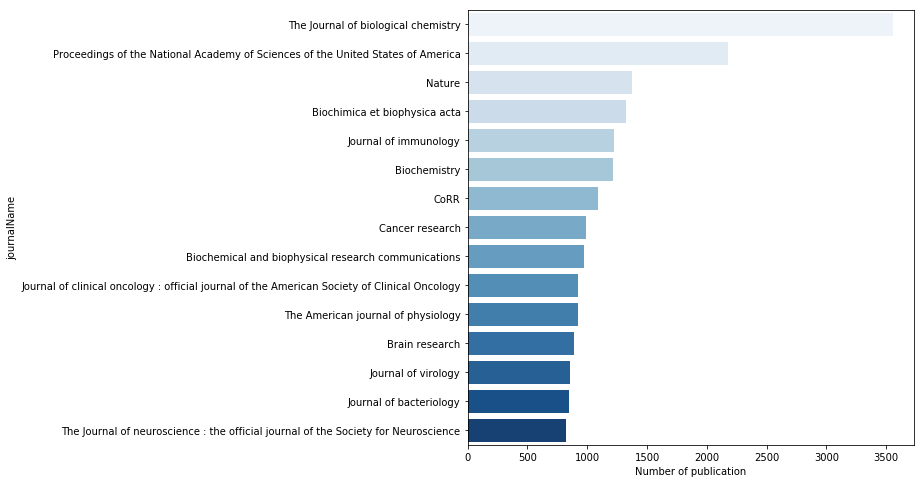

In [17]:
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(y=journal_count.head(15).index, x=journal_count.head(15), palette='Blues')
plt.xlabel('Number of publication')

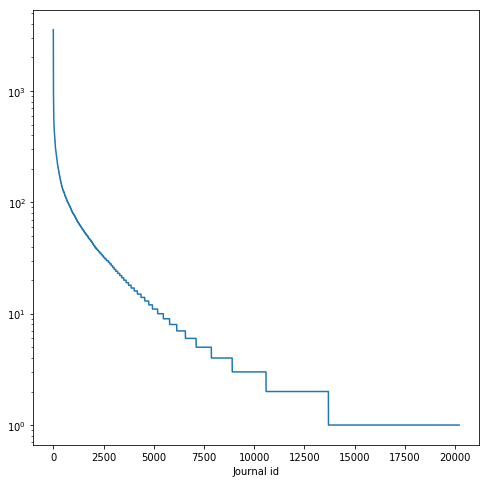

In [28]:
f, ax = plt.subplots(figsize=(8, 8))
plt.plot((journal_count.values))
plt.xlabel('Journal id')
ax.set_yscale('log')

In [25]:
journal_count.head(20)

journalName
The Journal of biological chemistry                                                             3554
Proceedings of the National Academy of Sciences of the United States of America                 2173
Nature                                                                                          1376
Biochimica et biophysica acta                                                                   1327
Journal of immunology                                                                           1226
Biochemistry                                                                                    1214
CoRR                                                                                            1088
Cancer research                                                                                  989
Biochemical and biophysical research communications                                              972
Journal of clinical oncology : official journal of the American Society of Clin